# Q-learning en el ambiente del Frozen Lake

<b>Autora</b>: Alicia Muñiz Jiménez


La clave para resolver problemas de aprendizaje por refuerzo (RL) es encontrar la política óptima ($\pi^{*}$) de la función de valor para el problema específico. El Q-learning es un algoritmo del tipo modelo libre del RL basado en valor y es un policy off-learner, es decir, depende del ensayo y error para actualizar su experiencia y conocimiento del entorno, ya que tienen que aprender la dinámica del sistema a través de la experiencia, y aprende el valor de la política óptima independientemente del tipo de acciones del agente, así como que las actualizaciones de la función de valor se basan en la ecuación de Bellman  (Jang, Kim, Harerimana y Kim, 2019). 


Su Q proviene de quality (cualidad en inglés), ya que el Q-learning representa qué tan útil es una acción en ganar una recompensa a futuro (Shyalika, 2019). Es así que el Q-learning estima la función $Q(s,a)$ que es el valor esperado de hacer una acción 'a' en un estado 's' para estimar la política óptima y la ecuación de actualización de los valores $Q(s,a)$ es la siguiente: 


$$
Q(s, a) = Q(s, a) + \alpha [ r(s, a) + γmax Q' (s',a') - Q(s, a) ]
$$


Donde: 

*   $r(s,a)$ = recompensa obetenida en ese estado dada una acción.
*   $γ$ = factor de descuento para el estado futuro (al que se transitará), su valor es fijo y puede tomar el rango de valores de [0,1].
*   $α$ = parámetro de aprendizaje, no es fijo ya que al inicio comienza en 1 y con cada iteración irá disminuyendo su valor hasta alcanzar el valor de 0 o un límite inferior definido de antemano (ej. 0.01).
*   $Q(s, a)$ = valor Q del estado actual dada la acción a.
*   $max Q'(s', a')$ = máxima futura recompesa esperada del estado nuevo al que se transitará.


Como se puede apreciar en la ecuación anterior, el Q-learning usa el método de diferencias temporales para la actualización o estimación de los valores Q, ya que sólo toma en cuenta el estado actual y el siguiente estado para estimar los valores Q (Matiisen, s. f.). Por otro lado, cuando el Q-learning es ejecutado se crea lo que se llama una tabla-Q, que es una matriz donde las filas normalmente representan cada estado posible y las columnas las acciones posibles en cada estado (Aggarwal, s.f. ). Por lo tanto, cada entrada de la matriz es un par estado-acción. La tabla siempre se inicializa con todos los valores en 0 y se actualiza cada entrada con la ecuación de actualización de los valores Q, de acuerdo con lo que el agente explora en cada iteración. La tabla al final sirve como referencia para que el agente pueda seleccionar la mejor acción basada en los valores Q.

Finalmente, es importante recalcar que en el Q-learning el agente trabaja con una política epsilon-greedy, mas esta política no tiene valores fijos, sino que al inicio el algoritmo tiene un  epsilon de 1 y con cada iteración este valor va disminuyendo hasta terminar en 0 o en un límite inferior como 0.01, si es que así se especifica de antemano (Matiisen, s.f.). Esto se debe a que como el algoritmo no tiene conocimiento de la dinámica del sistema al inicio, entonces necesita explorar mucho para conocer el entorno, pero conforme va conociendo más del entorno puede explotar cada vez más y no solo explorar. 

Después de la breve introducción al Q-learning, ahora se procederá con un ejemplo práctico sobre dos agentes agentes que interactúan en el entorno virtual "Frozen Lake" del gimnasio OpenAI, esto para entender mejor el Q-learning y las diferencias que se pueden observar al compararlo con un agente que tiene una política de elección de comportamiento de acciones aleatorias. 



## Explicación del ambiente

La documentación de la paquetería *gymnasium* describe las sigueintes características del ambiente *Frozen Lake* (Farama Foundation, 2023): 

* **Estado de acciones (4):**

    - 0 = Izquierda
    - 1 = Abajo
    - 2 = Derecha
    - 3 = Arriba
    
* **Espacio observacional (16):** Se utilizará el ambiente de Frozen Lake con una cuadrícula de tamaño 4x4, por lo que el total de observaciones posibles (estados) son 16. 


* **Recompenzas:**

     - +1 si el agente alcanza la meta.
     - 0 si el agente cae en alún hoyo en el hielo.
     - 0 si el agente pasa por estados donde hay hielo congelado. 
     


# Código

**Instalación e importación de librerías**

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym 
import math, random

# Agente con acciones aleatorias

In [2]:
#Crea ambiente; render_mode='human' permite visualizar gráficamente el entorno 
env=gym.make("FrozenLake-v1",desc=["SHFF", "FFFF", "FFFH", "FFFG"], is_slippery=False, render_mode="human")
#Índices de las acciones
action_names = {0:'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}

#Número de acciones
action_space_size = env.action_space.n
#Número de cuadros
state_space_size = env.observation_space.n

print('Ambiente:\n{}\n Tamaño: {}; Núm. acciones: {}'.format(env.desc, state_space_size, action_space_size))

Ambiente:
[[b'S' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H']
 [b'F' b'F' b'F' b'G']]
 Tamaño: 16; Núm. acciones: 4


In [3]:
#Número de ensayos
ensayos = 3
for ensayos in range(1, ensayos+1):
    #Estado inicial
    estado = env.reset()
    done = False
    score = 0

    actions = []
    while not done:
        #Visualiza el ambiente
        #env.render() #Quitar comentario para visualizar
        #Muestrea una acción
        action = env.action_space.sample()
        actions.append(action_names[action])
        #Obtiene la recompensa por la acción
        _, reward, done, _, _ = env.step(action)
        score += reward

    print('Ensayo:{}\n\tAcciones:{}; Recompensa: {}'.format(ensayos, actions, score))

env.close()

Ensayo:1
	Acciones:['Izquierda', 'Derecha']; Recompensa: 0.0
Ensayo:2
	Acciones:['Arriba', 'Arriba', 'Izquierda', 'Derecha']; Recompensa: 0.0
Ensayo:3
	Acciones:['Abajo', 'Arriba', 'Arriba', 'Derecha']; Recompensa: 0.0


Un ejemplo de la exploración que hace el agente se puede visualizar de la siguiente forma:

![image](Images/FrozenLake.gif)

## Agente con el algorito de Q-learning

Se usó como base el código de Brooker (2020) sobre su agente de Q-learning en el ambiente de CartPole-v1, pero se adaptó para el ambiente Frozen Lake y el tipo de variables que maneja este ambiente. Además se implementaron cambios respecto al ambiente original, para fines didácticos y cambios en el código para adaptarlo a las nuevas actualizaciones de la paquetería gymnasium. De igual forma, se agregó una etapa de prueba al final para comprobar qué tan bien aprendió el agente. 

In [4]:
env=gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFFH", "FFFG"], is_slippery=False, render_mode="ansi")

In [5]:
#Tabla de valores Q inicalmente con 0s
Q_table= np.zeros((state_space_size, action_space_size))
pd.DataFrame(data=Q_table, columns=['Izquierda', 'Abajo', 'Derecha', 'Arriba'])

,Izquierda,Abajo,Derecha,Arriba
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [6]:
def policy(state, Q_table):
    """Elije la acción en base a una política ambiciosa"""
    return np.argmax(Q_table[state])

def new_Q_value( reward, new_state, Q_table, discount_factor=1 ):
    """Diferencia temporta para acutaliza el valor-Q del par estado-acción"""
    #obtiene Q*
    future_optimal_value = np.max(Q_table[new_state])
    #R + \gammaxQ*
    learned_value = reward + discount_factor * future_optimal_value
    
    return learned_value

def learning_rate(n, min_rate=0.01 ):
    """Apata la tasa de aprendizaje"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

def exploration_rate(n, min_rate= 0.1 ):
    """Adapta la tasa de exploración"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [7]:
puntajes_ep = []
#Número de episodios
n_episodes = 100
for e in range(1, n_episodes+1):
    #Estado inicial
    current_state = env.reset()[0]
    done = False
    score = 0
    actions = []
    while done==False:
        #Escoje acción de acuerdo con la política
        action = policy(current_state, Q_table)
        
        #Genera núm. aleatorio, si es menor al rango de exploración
        #realiza una acción aleatoria
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample()
        actions.append(action_names[action])
         
        #Cálcula la recompensa y actualiza las observaciones
        obs, reward, done, _, _ = env.step(action)
        new_state = obs
        score += reward

        #Rango de aprendizaje
        lr = learning_rate(e)
        #Actualiza la tabla para valores Q
        learnt_value = new_Q_value(reward, new_state, Q_table )
        old_value = Q_table[current_state, action]
        #Cálcula el nuevo valor Q: (1-l)*Q_t + l*Q_t+1
        Q_table[current_state, action] = (1-lr)*old_value + lr*learnt_value
        #Cambia al nuevo estado
        current_state = new_state
    puntajes_ep.append(score)
    if e % 100 == 0:
        print('Episode {}\n\tPuntaje:{}; Acciones:{}'.format(e, score, actions))


Episode 100
	Puntaje:0.0; Acciones:['Derecha', 'Abajo']


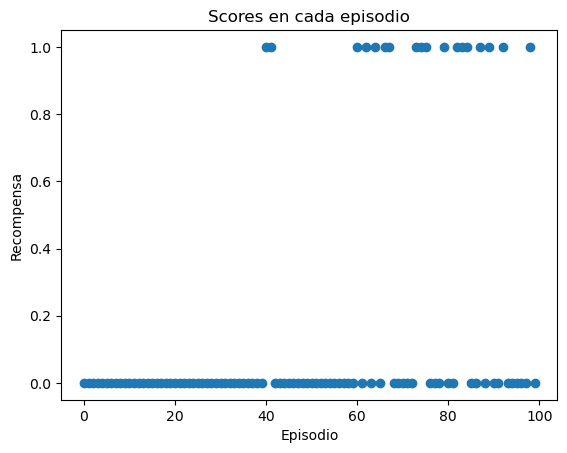

In [8]:
import matplotlib.pyplot as plt

plt.plot(puntajes_ep,'o')
plt.title('Scores en cada episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.show()

In [9]:
pd.DataFrame(data=Q_table, columns=['Izquierda', 'Abajo', 'Derecha', 'Arriba'])

,Izquierda,Abajo,Derecha,Arriba
0,0.982011,0.995040,0.999982,0.997014
1,0.995936,0.000000,0.999988,0.985112
2,0.978925,0.999991,0.954103,0.995505
3,0.998937,0.122738,0.852224,0.690136
4,0.428628,0.903808,0.000000,0.999740
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.999992,0.930017,0.964474
7,0.411164,0.000000,0.000000,0.968456
8,0.000000,0.000000,0.391208,0.996588
9,0.916456,0.000000,0.000000,0.000000


## Prueba de aprendizaje

In [10]:
env=gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFFH", "FFFG"], is_slippery=False, render_mode="human")

In [11]:
n_episodes_t = 3
for e in range(1, n_episodes_t+1):
    #Estado inicial
    current_state = env.reset()[0]
    done = False
    score = 0
    actions
    while done==False:
        #Elije acción de acuerdo a política 
        action = policy(current_state, Q_table)
        actions.append(action_names[action])
        #Actúa en el ambiente y cálcula recompensa
        obs, reward, done, _,_= env.step(action)
        new_state = obs        
        score += reward
        #Actualiza el estado
        current_state = new_state


    print('Episodio: {}\n\tAcciones: {}; Puntaje: {}'.format(e, actions, score))
    
env.close()

Episodio: 1
	Acciones: ['Derecha', 'Abajo', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha']; Puntaje: 1.0
Episodio: 2
	Acciones: ['Derecha', 'Abajo', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha']; Puntaje: 1.0
Episodio: 3
	Acciones: ['Derecha', 'Abajo', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Derecha']; Puntaje: 1.0


![image](Images/SolFrozenLake.gif)

**Referencias:** 

* Aggarwal, R. (s. f.). Q-learning - Reinforcement Learning. Recuperado el 15 de diciembre de 2022. https://miet.ac.in/assets/uploads/cs/Q%20Learning.pdf

* Brooker, R. (2020). OpenAI Gym: CartPole-v1 - Q-Learning [Youtube]. https://www.youtube.com/watch?v=JNKvJEzuNsc&t=227s

* Jang, B. Kim, M. Harerimana, G. y Kim, J.W. (2019). "Q-Learning Algorithms: A Comprehensive Classification and Applications,". IEEE Access, vol. 7,133653-133667, doi: 10.1109/ACCESS.2019.2941229

* Matiisen, T. (s. f.). Q-learning [Presentación]. Recuperado el 15 de diciembre de 2022. https://courses.cs.ut.ee/MTAT.03.292/2014_spring/uploads/Main/Q-learning.pdf

* Farama Foundation. (2023). Frozen Lake. Gymnasium Documentation. Recuperado el 28 de marzo de 2023. https://gymnasium.farama.org/environments/toy_text/frozen_lake/

* Shyalika, C. (2019). A Beginners Guide to Q-Learning. En Towards Data Science. Recuperado el 8 de diciembre de 2022. https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c
